alphaAdige 8.181837694094263e-07
alphaSecchia 7.12347673088292e-07
alphaDoraBaltea 1.0258299629417912e-06
alphaTicino 1.0960549556412753e-09
alphaChiese 3.344150852851322e-05
alphaOglio 2.4455281710286436e-09
alphaTanaro 3.0412211352834637e-07
alphaPo1 0.0002955829369322437
alphaPo2 0.00013455721818187797
alphaPo3 1.1608459485666934e-06
alphaReno 2.89720702776789e-07
alphaLamone 5.527115116699035e-07
alphaSavio 0.0007505745767047163
alphaAdda 3.205855624243772e-07
alphaTaro 1.8366011418912963e-07
alphaMincio 7.300167584344479e-10
alphaSesia 0.00021619996534319943
alphaOrco 1.7964091149530896e-06
alphaLambro 4.387541123057715e-06
alphaNaviglioGrande 1.027253524504874e-08
C_qms 1 : 0.9998005094218905 ; qms 1 : 1.2173449003093815e-05
C_qms 2 : 0.9998005094218905 ; qms 2 : 2.3972910439623347e-05
C_qms 3 : 0.9998005094218905 ; qms 3 : 4.023946500990201e-05
C_qms 4 : 0.9998005094218905 ; qms 4 : 2.924580605785595e-05
C_qms 5 : 0.9998005094218905 ; qms 5 : 1.938535251927126e-05
C_qms 6 : 0.99

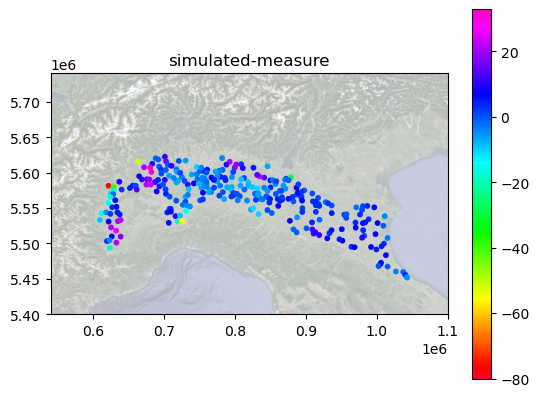

fobj Interpol: 6.639600907256689


In [9]:
#!/usr/bin/env python
# coding: utf-8

# In[20]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from vtk import vtkXMLUnstructuredGridReader

import scipy.stats as stats
import subprocess
import scipy as sp
import rasterio
import numpy as np

import meshio
import pandas as pd
from matplotlib import pyplot as plt
import pyvista

import os
import shutil
import datetime
import math



meshC =  pyvista.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\gridTetraCoarse.vtu")

# In[21]:



dfRiver = pd.read_csv('C:\\Users\\Andrea\\Documents\\Flow\\Optimization\\headData\\averageInTime\\wellHeadRivers2013_2020.csv')
wellLocRiver = dfRiver
wellLocRiver['Bottom'] = wellLocRiver['quota[m]'] - wellLocRiver['depth']

df = pd.read_csv('C:\\Users\\Andrea\\Documents\\Flow\\Optimization\\headData\\averageInTime\\wellHeadPo2013_2020.csv')
wellLoc = df
wellLoc['Bottom'] = wellLoc['quota[m]'] - wellLoc['depth']


weights = np.loadtxt('weights.txt')

nRecostruction = sum(weights[:,1])


# In[22]:


#function for determine qms and K. The model calibration is driven by all the head data
def flowSimulationH(P,*args):

    myfile = open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po1HP.prj", "rt")
    contents = myfile.readlines()
    myfile.close()
    weights = np.loadtxt('weights.txt')
    nRecostruction = sum(weights[:,1])

    wordX = 'permeability' ## it is set according to the uncertainty probability.
    nameOfRivers = ['Adige',
                    'Secchia',
                    'DoraBaltea',
                    'Ticino',
                    'Chiese',
                    'Oglio',
                    'Tanaro',
                    'Po1',
                    'Po2',
                    'Po3',
                    'Reno',
                    'Lamone',
                    'Savio',
                    'Adda',
                    'Taro',
                    'Mincio',
                    'Sesia',
                    'Orco',
                    'Lambro',
                    'NaviglioGrande',
                    'none']

    al = 0
    worda = 'alpha' + nameOfRivers[al]
    wordqm = 'qms'
    wordh0 = 'h0'
    j=0
    qms = 0
    h0 = 0
    P0 = h0*9810
    
    # set the K parameters 
    Kappa1 = (10**P[0]*weights[0,:] + 10**P[1]*weights[1,:] + 
              10**P[2]*weights[2,:] + 10**P[3]*weights[3,:] + 
              10**P[4]*weights[4,:] + 10**P[5]*weights[5,:])/nRecostruction
    meshC['Kappa1'] = Kappa1
    meshC.save(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\gridTetraCoarse.vtu")
    for i in range(len(contents)):
        
#         if wordX in contents[i]:
#             value = contents[i+2].split('<value>').pop().split('</value>')[0]
#             if j>0:
#                 K = 10**P[j-1]
#                 value2= str(K)
#                 contents[i+2] = contents[i+2].replace(value, value2)
#                 permName = 'k%1d' % j 
#                 print(permName, value2)
#             j += 1

        #set the alpha values
        if worda in contents[i]:
            if '<value>' in contents[i+2]:
                value = contents[i+2].split('<value>').pop().split('</value>')[0]
                a = 10**args[0][al]
                
                #a = args[al]

                value2= str(a)
                contents[i+2] = contents[i+2].replace(value, value2)
                print(worda, value2)
                al += 1
                worda = 'alpha' + nameOfRivers[al]
               
        #set the qms values          
        if wordqm in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    qmsValue2 = P[-1]*float(value)
                    value2= str(qmsValue2)
                    contents[i+2] = contents[i+2].replace(value, value2)                    
                    print('C_qms', qms+1 ,':', P[-1],';', 'qms', qms+1 , ':' , value2)
                    qms += 1
                    
        if wordh0 in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    value2= str(P0)
                    contents[i+2] = contents[i+2].replace(value, value2)                  
    
    
            
    with open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj", 'w') as file:
        file.writelines( contents )
    
    
    subprocess.check_call([r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs-6.4.3-16-g9a7564950-Windows-10.0.22000-python-3.10.7-utils\bin\ogs.exe", r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj"])

    sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
    reader = vtkXMLUnstructuredGridReader()
    reader.SetFileName(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
    reader.Update()

    # Get the point coordinates and pressure data
    points = reader.GetOutput().GetPoints().GetData()
    pressure = reader.GetOutput().GetPointData().GetArray("pressure")

    # Create an interpolator object
    interp = LinearNDInterpolator(points, pressure)

    # Sample the interpolated value in multiple 3D points of your grid
    points = sample
    interpolated_values = interp(points)
    simulatedP = interpolated_values
    #simulatedP = (simulatedP>=0)*simulatedP+(simulatedP<0)*0
    simulatedH = (simulatedP)/9810+sample[:,2]
    #simulatedH = (simulatedH<=wellLoc['quota[m]'])*simulatedH+(simulatedH>wellLoc['quota[m]'])*wellLoc['quota[m]']
    sum_of_non_nan_elements = np.nansum(((simulatedH-np.array(wellLoc['averageHead[m]']))**2)**(1/2))
    number_of_non_nan_elements = np.count_nonzero(~np.isnan(simulatedH))
    fobj = sum_of_non_nan_elements / number_of_non_nan_elements

    print('MAE: ',fobj)
    return fobj

# In[ ]:





P = [ math.log10(1.0175798951590066e-09),
         math.log10(3.834766652828529e-09),
        math.log10(2.2403786421078086e-13),
        math.log10(1.5685931737322937e-10), 
        math.log10(2.125822903488283e-15),
        math.log10(5.044748775747056e-18),
   0.9998005094218905]

 #log_10(k1) #log_10(k2) #log_10(k3) #log_10(k4) #log_10(k5) #log_10(k6) #C_qms1-29


args1 = [-6.08714914, -6.14730799, -5.98892462, -8.96016767, -4.47571414, -8.61162733,
 -6.516952,   -3.52932064, -3.871093,   -5.93522541, -6.53802047, -6.25750149,
 -3.12460615, -6.49405604, -6.73598515, -9.13666717, -3.66514438, -5.74559475,
 -5.3577788,  -7.98832236,  4.96167782]   

flowSimulationH(P,args1)


#plot the error  in a map
mesh = meshio.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
data = mesh.points
sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
# kdtree=sp.spatial.KDTree(data)
# dist,points=kdtree.query(sample,1)
# simulatedP = mesh.point_data['pressure'][points].T
# simulatedP = (simulatedP>=0)*simulatedP+(simulatedP<0)*0
# simulatedH = (simulatedP)/9810+sample[:,2]
# simulatedH = (simulatedH<=wellLoc['quota[m]'])*simulatedH+(simulatedH>wellLoc['quota[m]'])*wellLoc['quota[m]']

# fobj = (sum(((simulatedH-np.array(wellLoc['head[m]']))**2)**(1/2)))/len(wellLoc['head[m]'])
# print('fobj:',fobj)
# diff = simulatedH-np.array(wellLoc['head[m]'])
# err = diff[~np.isnan(simulatedH)]
# img = plt.imread(r"C:\Users\Andrea\Documents\Flow\Optimization\background.tif")
# img = np.array(img)
# img[:,:,3] = img[:,:,3]*0.32
# ext = [540000.0000, 1100000.0000,5400000.0000,5740000.0000]
# plt.imshow(img, zorder=0, extent=ext)
# plt.scatter(sample[:,0],sample[:,1],zorder=1, s=10, c=err, cmap='gist_rainbow', vmin=min(err), vmax=max(err))#vmin=min(err), vmax=max(err))
# plt.colorbar()
# plt.title('simulated-measure')
# plt.show()         



# Load the .vtu file
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
reader.Update()

# Get the point coordinates and pressure data
points = reader.GetOutput().GetPoints().GetData()
pressure = reader.GetOutput().GetPointData().GetArray("pressure")

# Create an interpolator object
interp = LinearNDInterpolator(points, pressure)

# Sample the interpolated value in multiple 3D points of your grid
points = sample
interpolated_values = interp(points)
simulatedP = interpolated_values
#simulatedP = (simulatedP>=0)*simulatedP+(simulatedP<0)*0
simulatedH = (simulatedP)/9810+sample[:,2]
#simulatedH = (simulatedH<=wellLoc['quota[m]'])*simulatedH+(simulatedH>wellLoc['quota[m]'])*wellLoc['quota[m]']
sum_of_non_nan_elements = np.nansum(((simulatedH-np.array(wellLoc['averageHead[m]']))**2)**(1/2))
number_of_non_nan_elements = np.count_nonzero(~np.isnan(simulatedH))
fobj = sum_of_non_nan_elements / number_of_non_nan_elements

diff = simulatedH-np.array(wellLoc['averageHead[m]'])
err = diff
err[np.isnan(simulatedH)] = 0

img = plt.imread(r"C:\Users\Andrea\Documents\Flow\Optimization\background.tif")
img = np.array(img)
img[:,:,3] = img[:,:,3]*0.32
ext = [540000.0000, 1100000.0000,5400000.0000,5740000.0000]
plt.imshow(img, zorder=0, extent=ext)
plt.scatter(sample[:,0],sample[:,1],zorder=1, s=10, c=err, cmap='gist_rainbow', vmin=min(err), vmax=max(err))#vmin=min(err), vmax=max(err))
plt.colorbar()
plt.title('simulated-measure')
plt.show()         


print('fobj Interpol:',fobj)
                 




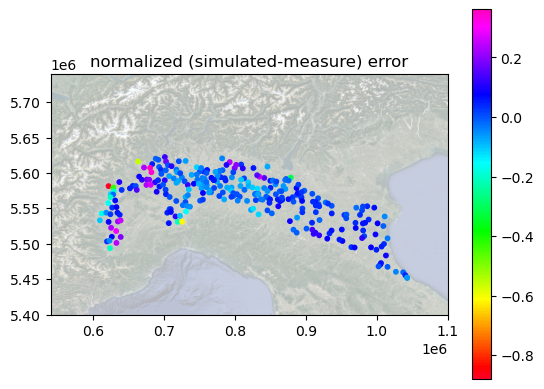

fobj Interpol: 0.07293410485603079


In [10]:
simulatedHNrom = (simulatedH-wellLoc['averageHead[m]'].mean())/wellLoc['averageHead[m]'].std() 
averageHeadNorm = (np.array(wellLoc['averageHead[m]'])-wellLoc['averageHead[m]'].mean())/wellLoc['averageHead[m]'].std()

sum_of_non_nan_elements = np.nansum(((simulatedHNrom-averageHeadNorm)**2)**(1/2))
number_of_non_nan_elements = np.count_nonzero(~np.isnan(simulatedH))
fobj = sum_of_non_nan_elements / number_of_non_nan_elements

diffNorm = simulatedHNrom-averageHeadNorm
errNorm = diffNorm
errNorm[np.isnan(simulatedH)] = 0

img = plt.imread(r"C:\Users\Andrea\Documents\Flow\Optimization\background.tif")
img = np.array(img)
img[:,:,3] = img[:,:,3]*0.32
ext = [540000.0000, 1100000.0000,5400000.0000,5740000.0000]
plt.imshow(img, zorder=0, extent=ext)
plt.scatter(sample[:,0],sample[:,1],zorder=1, s=10, c=errNorm, cmap='gist_rainbow', vmin=min(errNorm), vmax=max(errNorm))#vmin=min(err), vmax=max(err))
plt.colorbar()
plt.title('normalized (simulated-measure) error')
plt.show()         


print('fobj Interpol:',fobj)

In [11]:
# Filter the rows in "wellLoc" based on the common "id_left" values
filtered_wellLoc = wellLoc[wellLoc['id_left'].isin(wellLocRiver['id_left'])]

# Retrieve the values from the "averageHead[m]" column
average_head_values = filtered_wellLoc['averageHead[m]']
measuredHRiver = np.array(average_head_values)

simulatedHRiver= simulatedH[average_head_values.index]

In [12]:
len(simulatedHRiver)

138

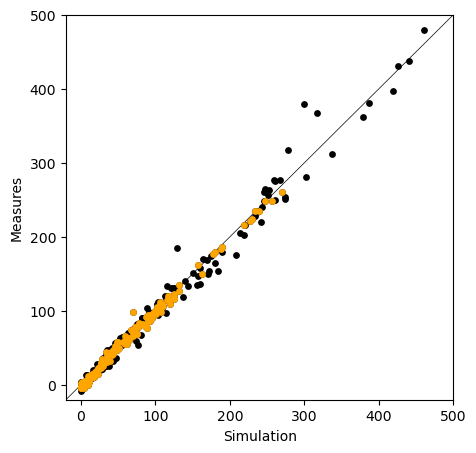

In [13]:
plt.figure(figsize=(5, 5))
plt.plot([-100,+1000], [-100,+1000], 'black', linewidth=0.5)
plt.scatter(simulatedH, wellLoc['averageHead[m]'], s=15, c='black', zorder=2)
plt.scatter(simulatedHRiver, measuredHRiver, s=15, c='orange', zorder=2)
plt.xlabel('Simulation')
plt.ylabel('Measures')
plt.xlim(-20, 500)
plt.ylim(-20, 500)
plt.show()

In [63]:
np.mean(np.absolute(simulatedH[wellLoc['averageHead[m]']<100] - wellLoc['averageHead[m]'][wellLoc['averageHead[m]']<100]))

4.523656777921681

In [64]:
np.mean(np.absolute(simulatedH[wellLoc['averageHead[m]']>100] - wellLoc['averageHead[m]'][wellLoc['averageHead[m]']>100]))

11.22414652081587

In [14]:
simulatedH1 = simulatedH.copy()
simulatedH1[-54] =np.array(wellLoc['averageHead[m]'])[-54]

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_1 = r2_score(simulatedH1, wellLoc['averageHead[m]'])
r2_2 = r2_score(simulatedHRiver, measuredHRiver)
MAE2 = mean_absolute_error(simulatedHRiver, measuredHRiver)



print("R2 score:", r2_1, r2_2, 'ma2e',MAE2)

R2 score: 0.9859287233013122 0.992648253553984 ma2e 3.8598072877847267


In [16]:
max(wellLoc['averageHead[m]'])

479.20311562385655

Average error: 0.8299390983070759
error standard deviation: 10.675066052216101


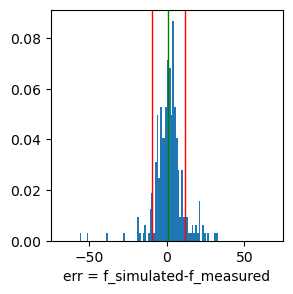

In [17]:
diff = simulatedH-np.array(wellLoc['averageHead[m]'])
err = diff[~np.isnan(simulatedH)]

counts, bins = np.histogram(err,bins=100, density=True)
plt.figure(figsize=(3, 3))
plt.stairs(counts, bins,fill=True)
plt.xlabel('err = f_simulated-f_measured')
plt.axvline(x = np.average(err), color = 'g', label = 'Average error',linewidth=1)
plt.axvline(x = np.average(err) + np.std(err), color = 'r', label = 'Avg + std',linewidth=1)
plt.axvline(x = np.average(err) - np.std(err), color = 'r', label = 'Avg - std',linewidth=1)
mu = np.average(err)
sigma =  np.std(err)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.xlim(-75, 75)
#plt.plot(x, stats.norm.pdf(x, mu, sigma),label = 'Normal Distribution')
#plt.legend()
print('Average error:', mu)
print('error standard deviation:', sigma)


Average error: 0.009116642109300768
error standard deviation: 0.11726252792490074


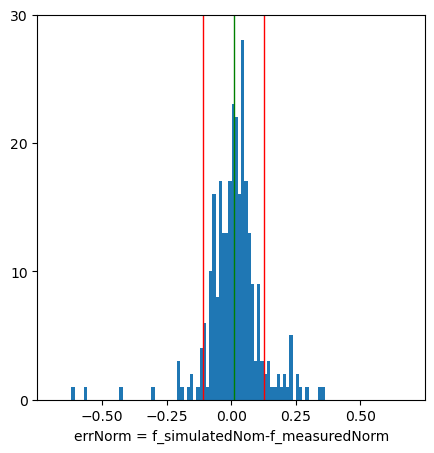

In [18]:
diffNorm = simulatedHNrom-averageHeadNorm
errNorm = diffNorm[~np.isnan(simulatedH)]

counts, bins = np.histogram(errNorm,bins=100, density=False)
plt.figure(figsize=(5, 5))
plt.stairs(counts, bins,fill=True)
plt.xlabel('errNorm = f_simulatedNom-f_measuredNorm')
plt.axvline(x = np.average(errNorm), color = 'g', label = 'Average Norm error',linewidth=1)
plt.axvline(x = np.average(errNorm) + np.std(errNorm), color = 'r', label = 'Avg + std',linewidth=1)
plt.axvline(x = np.average(errNorm) - np.std(errNorm), color = 'r', label = 'Avg - std',linewidth=1)
mu = np.average(errNorm)
sigma =  np.std(errNorm)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

plt.yticks(np.linspace(0, 30, num=4))
plt.xticks(np.linspace(-0.5, +0.5, num=5))
plt.xlim(-0.75, 0.75)
#plt.plot(x, stats.norm.pdf(x, mu, sigma),label = 'Normal Distribution')
#plt.legend()
print('Average error:', mu)
print('error standard deviation:', sigma)


In [19]:
25945510*25.4

659015954.0

In [20]:
18.66*25.4/1000*81000*1000000

38391084000.0

In [21]:
483293366/(25945510*25.4)

0.733356094137897

# distribution of the permeabilities values

In [22]:
# Load the .vtu file
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
reader.Update()

# Get the point coordinates and pressure data
points = reader.GetOutput().GetPoints().GetData()
pressure = reader.GetOutput().GetPointData().GetArray("pressure")

In [23]:
meshC =  pyvista.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\gridTetraCoarse.vtu")

In [24]:
logK = np.log10(meshC['Kappa1'])
kk = meshC['Kappa1']

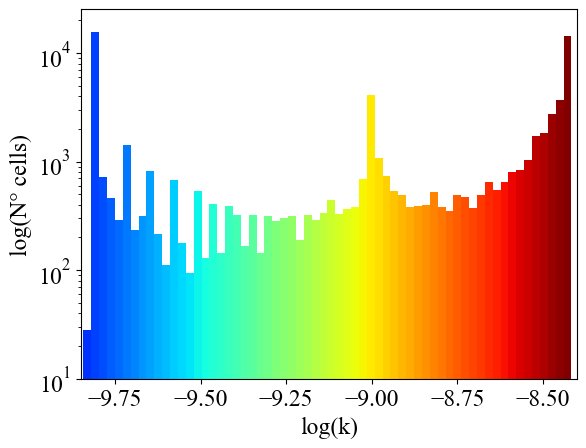

-10.14172493832869
-8.41626105791375


In [57]:

# Set font properties for both axes
font = {'family': 'Times New Roman', 'size': 17}
plt.rc('font', **font)


counts, bins = np.histogram(logK, bins=75, density=False)
colormap = 'jet'  # Specify the colormap (jet in this case)

vector = np.linspace(0, 1, 75)
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=plt.cm.get_cmap(colormap)(vector))
plt.xlabel('log(k)')
plt.ylabel('log(N° cells)')
plt.yscale('log')  # Set the y-axis to log scale
plt.ylim(10, plt.ylim()[1]) 
plt.xlim(-9.85, -8.4) 



plt.show()
print(min(logK))
print(max(logK))


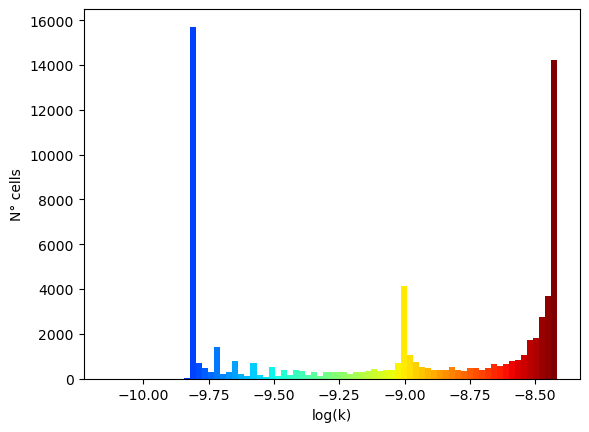

-10.14172493832869
-8.41626105791375


In [25]:
counts, bins = np.histogram(logK, bins=75, density=False)
colormap = 'jet'  # Specify the colormap (jet in this case)

vector = np.linspace(0, 1, 75)
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=plt.cm.get_cmap(colormap)(vector))
plt.xlabel('log(k)')
plt.ylabel('N° cells')

plt.show()
print(min(logK))
print (max(logK))




In [26]:
print(bins)
print(counts)

[-10.14172494 -10.11871875 -10.09571257 -10.07270638 -10.0497002
 -10.02669401 -10.00368783  -9.98068164  -9.95767546  -9.93466927
  -9.91166309  -9.8886569   -9.86565072  -9.84264453  -9.81963835
  -9.79663216  -9.77362598  -9.75061979  -9.72761361  -9.70460742
  -9.68160124  -9.65859505  -9.63558887  -9.61258268  -9.5895765
  -9.56657031  -9.54356413  -9.52055794  -9.49755176  -9.47454557
  -9.45153939  -9.4285332   -9.40552702  -9.38252083  -9.35951465
  -9.33650846  -9.31350228  -9.29049609  -9.26748991  -9.24448372
  -9.22147754  -9.19847135  -9.17546517  -9.15245898  -9.1294528
  -9.10644661  -9.08344043  -9.06043424  -9.03742805  -9.01442187
  -8.99141568  -8.9684095   -8.94540331  -8.92239713  -8.89939094
  -8.87638476  -8.85337857  -8.83037239  -8.8073662   -8.78436002
  -8.76135383  -8.73834765  -8.71534146  -8.69233528  -8.66932909
  -8.64632291  -8.62331672  -8.60031054  -8.57730435  -8.55429817
  -8.53129198  -8.5082858   -8.48527961  -8.46227343  -8.43926724
  -8.41626106

In [27]:
print(10**-9.06043424)
print(10**-8.5)

8.700931708552978e-10
3.1622776601683795e-09


In [28]:
counts[68]


838

In [29]:
10**bins[68]

2.6466447208613215e-09

In [30]:
# river in outflow analysis

In [31]:
rivers_files = [r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Taro.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Adda.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Lamone.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Savio.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po7.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Reno.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po6.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_14.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po4.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po2.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po3.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Po1.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Oglio.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Tanaro.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Chiese.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_DoraBaltea.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Ticino.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Adriatico.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Secchia.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_NaviglioGrande.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Lambro.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_LambroSud.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Orco.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Sesia.vtu",
r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_Mincio.vtu"]

In [32]:
meshO =  pyvista.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")

In [33]:
q_darcy = meshO['v']
q_darcy

pyvista_ndarray([[ 4.32946418e-06,  1.05592071e-05, -1.18166574e-07],
                 [ 4.55005569e-06,  1.29168312e-05,  5.02776771e-08],
                 [ 4.93700268e-06,  1.22314366e-05,  1.19331444e-07],
                 ...,
                 [ 3.41252354e-06,  6.71734595e-06, -3.05069769e-07],
                 [ 6.70266586e-06, -3.67607575e-05, -2.48182153e-07],
                 [ 2.65685336e-06,  4.98644500e-06, -5.44870346e-09]])

In [34]:
for ir in range(len(rivers_files)):

    meshR = pyvista.read(rivers_files[ir])

    # Get the coordinates of all points in the grid
    pointsr = meshR.points

    flowOut = np.zeros(len(pointsr))
    # Print the coordinates of each point
    for i, pointr in enumerate(pointsr):

        matching_rows = np.all(points == pointsr[i], axis=1)
        # Get indices of matching rows
        matching_indices = np.where(matching_rows)[0]

        if len(matching_indices) > 1: 
            print('more than 1 pt. match Error!')
        else:
            # Print matching rows
            for index in matching_indices:

                if q_darcy[index][2]>0:
                    flowOut[i] = 1

                else:
                    flowOut[i] = 0
    meshR.point_data['flowOut'] = flowOut.astype('uint64') 

    # Extract the file name from the file path
    file_name = os.path.basename(rivers_files[ir])

    # Print the extracted file name
    meshR.save("C:\\Users\\Andrea\\Documents\\Flow\\OpenGeoSys\\ogs6hetPermAquiferLim13-19\\out_" + file_name)



### calucalte the postirior covariance matrix

In [35]:
#function for determine qms and K. The model calibration is driven by all the head data


def fill_nan_with_average(array):
    filled_array = array.copy()
    nan_indices = np.isnan(filled_array)

    for i in range(len(filled_array)):
        if nan_indices[i]:
            prev_value = filled_array[i - 1]
            next_value = filled_array[i + 1]

            if np.isnan(prev_value) or np.isnan(next_value):
                # If previous or next value is also NaN, skip filling
                print('consecutive Nan!!')
                continue

            filled_array[i] = (prev_value + next_value) / 2

    return filled_array




def flowSimulationHCovM(P,*args):

    myfile = open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po1HP.prj", "rt")
    contents = myfile.readlines()
    myfile.close()
    
    wordX = 'permeability' ## it is set according to the uncertainty probability.
    nameOfRivers = ['Adige',
                    'Secchia',
                    'DoraBaltea',
                    'Ticino',
                    'Chiese',
                    'Oglio',
                    'Tanaro',
                    'Po1',
                    'Po2',
                    'Po3',
                    'Reno',
                    'Lamone',
                    'Savio',
                    'Adda',
                    'Taro',
                    'Mincio',
                    'Sesia',
                    'Orco',
                    'Lambro',
                    'NaviglioGrande',
                    'none']

    al = 0
    worda = 'alpha' + nameOfRivers[al]
    wordqm = 'qms'
    wordh0 = 'h0'
    j=0
    qms = 0
    h0 = 0
    P0 = h0*9810
    
    # set the K parameters 
    Kappa1 = (10**P[0]*weights[0,:] + 10**P[1]*weights[1,:] + 
              10**P[2]*weights[2,:] + 10**P[3]*weights[3,:] + 
              10**P[4]*weights[4,:] + 10**P[5]*weights[5,:])/nRecostruction
    meshC['Kappa1'] = Kappa1
    meshC.save(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\gridTetraCoarse.vtu")
    for i in range(len(contents)):
        
#         if wordX in contents[i]:
#             value = contents[i+2].split('<value>').pop().split('</value>')[0]
#             if j>0:
#                 K = 10**P[j-1]
#                 value2= str(K)
#                 contents[i+2] = contents[i+2].replace(value, value2)
#                 permName = 'k%1d' % j 
#                 print(permName, value2)
#             j += 1

        #set the alpha values
        if worda in contents[i]:
            if '<value>' in contents[i+2]:
                value = contents[i+2].split('<value>').pop().split('</value>')[0]
                a = 10**args[0][al]
                
                #a = args[al]

                value2= str(a)
                contents[i+2] = contents[i+2].replace(value, value2)
                #print(worda, value2)
                al += 1
                worda = 'alpha' + nameOfRivers[al]
               
        #set the qms values          
        if wordqm in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    qmsValue2 = P[-1]*float(value)
                    value2= str(qmsValue2)
                    contents[i+2] = contents[i+2].replace(value, value2)                    
                    #print('C_qms', qms+1 ,':', P[-1],';', 'qms', qms+1 , ':' , value2)
                    qms += 1
                    
        if wordh0 in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    value2= str(P0)
                    contents[i+2] = contents[i+2].replace(value, value2)                  
    
    
            
    with open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj", 'w') as file:
        file.writelines( contents )
    
    
    subprocess.check_call([r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs-6.4.3-16-g9a7564950-Windows-10.0.22000-python-3.10.7-utils\bin\ogs.exe", r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj"])

    sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
    reader = vtkXMLUnstructuredGridReader()
    reader.SetFileName(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
    reader.Update()

    # Get the point coordinates and pressure data
    points = reader.GetOutput().GetPoints().GetData()
    pressure = reader.GetOutput().GetPointData().GetArray("pressure")

    # Create an interpolator object
    interp = LinearNDInterpolator(points, pressure)

    # Sample the interpolated value in multiple 3D points of your grid
    points = sample
    interpolated_values = interp(points)
    simulatedP = interpolated_values
    #simulatedP = (simulatedP>=0)*simulatedP+(simulatedP<0)*0
    simulatedH = (simulatedP)/9810+sample[:,2]
    filled_array = fill_nan_with_average(simulatedH)   
    
    return filled_array

hP = flowSimulationHCovM(P,args1)

variance = np.var(hP-np.array(wellLoc['averageHead[m]']), ddof=1)




In [36]:

def calculate_jacobian(f, x, dx, args , hP):
    """
    Calculate the Jacobian matrix for a function f at point x with step size dx.
    
    Args:
        f (function): The function to calculate the Jacobian matrix for.
        x (ndarray): The point at which to calculate the Jacobian matrix.
        dx (float): The step size for numerical differentiation.
        args: hyper paramters of the mdoel
    
    Returns:
        ndarray: The Jacobian matrix.
    """
    n = len(x)
    nh = len(hP)
    J = np.zeros((nh, n))
    x_plus_dx = x.copy()
    x_minus_dx = x.copy()

    for i in range(n):
        x_plus_dx[i] += dx
        x_minus_dx[i] -= dx
        J[:, i] = (f(x_plus_dx, args) - f(x_minus_dx, args)) / (2 * dx)
        x_plus_dx[i] = x[i] 
        x_minus_dx[i] = x[i]# restore the original value of x[i]
        print('parameter',i, 'done!')
    
    return J

x = P
f = flowSimulationHCovM # la tua funzione
dx = 10**(-5)

J = calculate_jacobian(f, x, dx, args1, hP)
print(J)

JT = J.T
F = 1*JT.dot(J) #F = 1/variance*JT.dot(J)
Sigma = np.linalg.inv(F)
print(variance)

parameter 0 done!
parameter 1 done!
parameter 2 done!
parameter 3 done!
parameter 4 done!
parameter 5 done!
parameter 6 done!
[[-6.84245910e+01 -2.73093373e+01  4.17691058e+00 ...  6.72487596e+00
   2.07739032e+02  5.72417210e+01]
 [-5.05053192e+01 -3.12924025e+01  2.75637501e+00 ...  4.23000574e+00
   1.32440488e+02  4.54323732e+01]
 [-1.31197613e+02 -2.45521119e+01  1.39503315e+00 ...  2.25540541e+00
   5.69450584e+01  7.31460454e+01]
 ...
 [-5.61243472e+00 -1.39548691e+00 -3.94811539e-01 ... -5.27522263e-01
  -3.60684009e+01  6.42874741e+00]
 [-2.10955544e+00 -1.53798000e+00 -4.17925079e-01 ... -2.77415427e-01
  -8.16618107e+00  2.65826670e+00]
 [-4.65738059e+00 -1.18362817e+00 -1.81504839e-01 ... -1.96068773e-01
  -2.43204076e+01  6.09064630e+00]]
114.58178225630267


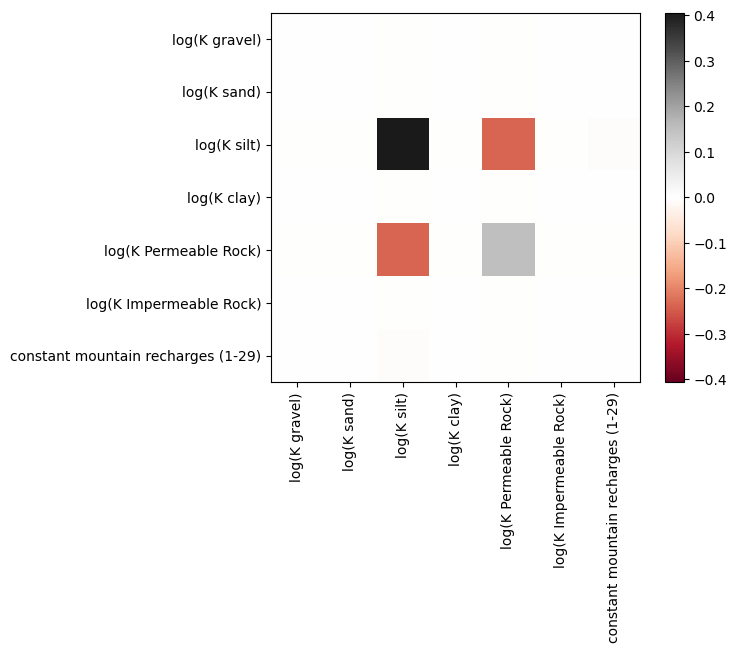

In [37]:
paramLabel=['log(K gravel)',
'log(K sand)',
'log(K silt)',
'log(K clay)',
'log(K Permeable Rock)',
'log(K Impermeable Rock)',
'constant mountain recharges (1-29)'
]
# Plot the covariance matrix
fig, ax = plt.subplots()
im = ax.imshow((Sigma), cmap='RdGy', interpolation='nearest', vmax = np.amax(Sigma), vmin = -np.amax(Sigma))
ax.set_yticks(np.arange(len(paramLabel)))
ax.set_yticklabels(paramLabel)
ax.set_xticks(np.arange(len(paramLabel)))
ax.set_xticklabels(paramLabel, rotation=90)
plt.colorbar(im)
plt.show()



In [38]:
print(variance)

114.58178225630267


In [39]:
#function for determine qms and K. The model calibration is driven by all the head data



def flowSimulationPCovM(args2,P):

    myfile = open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po1HP.prj", "rt")
    contents = myfile.readlines()
    myfile.close()
    
    wordX = 'permeability' ## it is set according to the uncertainty probability.
    nameOfRivers = ['Adige',
                    'Secchia',
                    'DoraBaltea',
                    'Ticino',
                    'Chiese',
                    'Oglio',
                    'Tanaro',
                    'Po1',
                    'Po2',
                    'Po3',
                    'Reno',
                    'Lamone',
                    'Savio',
                    'Adda',
                    'Taro',
                    'Mincio',
                    'Sesia',
                    'Orco',
                    'Lambro',
                    'NaviglioGrande',
                    'none']

    al = 0
    worda = 'alpha' + nameOfRivers[al]
    wordqm = 'qms'
    wordh0 = 'h0'
    j=0
    qms = 0
    h0 = 0
    P0 = h0*9810
    
    # set the K parameters 
    Kappa1 = (10**P[0]*weights[0,:] + 10**P[1]*weights[1,:] + 
              10**P[2]*weights[2,:] + 10**P[3]*weights[3,:] + 
              10**P[4]*weights[4,:] + 10**P[5]*weights[5,:])/nRecostruction
    meshC['Kappa1'] = Kappa1
    meshC.save(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\gridTetraCoarse.vtu")
    for i in range(len(contents)):
        
#         if wordX in contents[i]:
#             value = contents[i+2].split('<value>').pop().split('</value>')[0]
#             if j>0:
#                 K = 10**P[j-1]
#                 value2= str(K)
#                 contents[i+2] = contents[i+2].replace(value, value2)
#                 permName = 'k%1d' % j 
#                 print(permName, value2)
#             j += 1

        #set the alpha values
        if worda in contents[i]:
            if '<value>' in contents[i+2]:
                value = contents[i+2].split('<value>').pop().split('</value>')[0]
                a = 10**args2[al]
                
                #a = args[al]

                value2= str(a)
                contents[i+2] = contents[i+2].replace(value, value2)
                #print(worda, value2)
                al += 1
                worda = 'alpha' + nameOfRivers[al]
               
        #set the qms values          
        if wordqm in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    qmsValue2 = P[-1]*float(value)
                    value2= str(qmsValue2)
                    contents[i+2] = contents[i+2].replace(value, value2)                    
                    #print('C_qms', qms+1 ,':', P[-1],';', 'qms', qms+1 , ':' , value2)
                    qms += 1
                    
        if wordh0 in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    value2= str(P0)
                    contents[i+2] = contents[i+2].replace(value, value2)                  
    
    
            
    with open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj", 'w') as file:
        file.writelines( contents )
    
    
    subprocess.check_call([r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs-6.4.3-16-g9a7564950-Windows-10.0.22000-python-3.10.7-utils\bin\ogs.exe", r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po2.prj"])

    sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
    reader = vtkXMLUnstructuredGridReader()
    reader.SetFileName(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs6hetPermAquiferLim13-19\Po_ts_1_t_1.000000.vtu")
    reader.Update()

    # Get the point coordinates and pressure data
    points = reader.GetOutput().GetPoints().GetData()
    pressure = reader.GetOutput().GetPointData().GetArray("pressure")

    # Create an interpolator object
    interp = LinearNDInterpolator(points, pressure)

    # Sample the interpolated value in multiple 3D points of your grid
    points = sample
    interpolated_values = interp(points)
    simulatedP = interpolated_values
    #simulatedP = (simulatedP>=0)*simulatedP+(simulatedP<0)*0
    simulatedH = (simulatedP)/9810+sample[:,2]
    filled_array = fill_nan_with_average(simulatedH)
    
    
    return filled_array



P1 = args1[:20]
args2 = P

hP = flowSimulationPCovM(P1,args2)

variance = np.var(hP-np.array(wellLoc['averageHead[m]']), ddof=1)



In [40]:
x = P1
f = flowSimulationPCovM
dx = 10**(-5)

J = calculate_jacobian(f, x, dx, args2, hP)
print(J)

JT = J.T
F = 1*JT.dot(J) #F = 1/variance*JT.dot(J)
Sigma2 = np.linalg.inv(F)
print(variance)


parameter 0 done!
parameter 1 done!
parameter 2 done!
parameter 3 done!
parameter 4 done!
parameter 5 done!
parameter 6 done!
parameter 7 done!
parameter 8 done!
parameter 9 done!
parameter 10 done!
parameter 11 done!
parameter 12 done!
parameter 13 done!
parameter 14 done!
parameter 15 done!
parameter 16 done!
parameter 17 done!
parameter 18 done!
parameter 19 done!
[[ -3.42835556  -6.42385392  -1.57017432 ...  -5.88534789 -16.62516624
   20.58665036]
 [ -2.1306247   -4.22892531  -1.03238133 ...  -3.71479662 -10.80190684
   13.24104614]
 [ -1.15372687  -2.14674883  -0.52444932 ...  -1.95741589  -5.57238315
    6.89902206]
 ...
 [  0.27446548   0.43762471   0.14786992 ...   0.48122646   1.52008925
   -1.61495979]
 [  0.23691509   0.66615282   0.11412114 ...   0.19244198   1.12962961
   -0.98062291]
 [  0.09247034   0.14049261   0.08023039 ...   0.20506532   0.71418695
   -0.60518815]]
114.58178225630267


In [41]:
J1 = J[:20][:20]
J1[19,19]=0.0001
JT = J.T
F = JT.dot(J)
Sigma2 = np.linalg.inv(F)

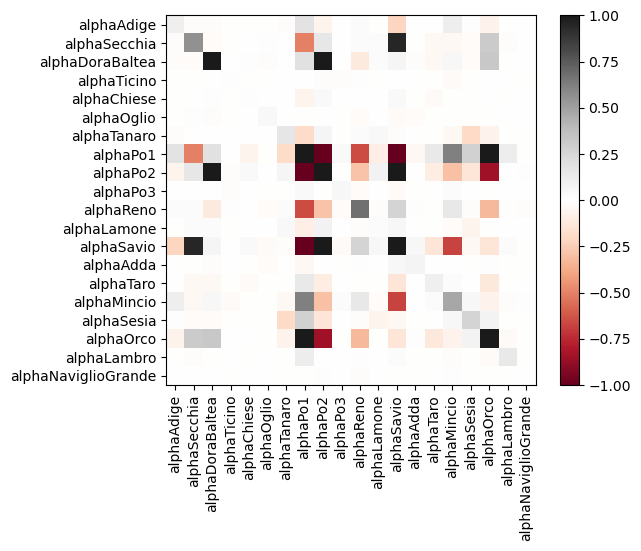

In [45]:
paramLabel=['alphaAdige',
'alphaSecchia',
'alphaDoraBaltea',
'alphaTicino',
'alphaChiese',
'alphaOglio',
'alphaTanaro',
'alphaPo1',
'alphaPo2',
'alphaPo3',
'alphaReno',
'alphaLamone',
'alphaSavio',
'alphaAdda',
'alphaTaro',
'alphaMincio',
'alphaSesia',
'alphaOrco',
'alphaLambro', 
'alphaNaviglioGrande',
]
# Plot the covariance matrix
fig, ax = plt.subplots()
im = ax.imshow((Sigma2), cmap='RdGy', interpolation='nearest',  vmax=1, vmin=-1 )
ax.set_yticks(np.arange(len(paramLabel)))
ax.set_yticklabels(paramLabel)
ax.set_xticks(np.arange(len(paramLabel)))
ax.set_xticklabels(paramLabel, rotation=90)
plt.colorbar(im)
plt.show()